#### Last Modified: Sept 27th, 2021 (Opal). 

# Lagrangian OpInf on Solar Wind Radial Speed dataset


In [1]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable
import rom_operator_inference as roi
from scipy import stats
import numpy as np 
import time
import astropy.units as u

In [2]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'size'   : 13}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

In [3]:
from code.hux_propagation import *
from code.archimedes_sprial import compute_phi_shift_forward
from code.numerical_methods import apply_numerical_method

# Import MHD solar wind velocity results.

In [4]:
# mas output - br, rho, vr
mas_path = get_mas_path(cr="2218")
model = MASOutput(mas_path)
print(model.variables)

['br', 'rho', 'vr']


In [5]:
# read in MHD velocity results. 
vr_model = model['vr']

In [6]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# number of phi indexes 
n = len(p)
# delta phi
dp = p[1:] - p[:-1]
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
# 1 solar radii = 695,700 km
r = (vr_model.r_coords * u.solRad).to(u.km)
# change in r
dr = r[1:] - r[:-1]
# velocity profile 
f = vr_model.data
print(f.shape)

(128, 111, 140)


In [7]:
# increase radial vector.
r_new = np.linspace(r[0], r[-1], 600)

In [8]:
# make phi grid coarse. 
p_new = np.linspace(p[0],p[-1], 200)

In [9]:
# number of phi indexes 
n = len(p_new) 
# spacing in phi (longitude)
dp = p_new[1] - p_new[0]

In [10]:
# set up hyper-parameters for acceleration. 
omega_rot = (2 * np.pi) / (25.38 * 86400)
r0=30 
alpha=0.15
rh=50 

# set up the first l indexes used for training. 
l = int(0.7*(len(r_new)))

# SVD cumulative energy threshold.
thresh = .99999

In [11]:
def compute_phi_shift_forward(p, r, v, omega=(2 * np.pi) / (25.38 * 86400), method=None):
    # initialize phi shift matrix. 
    phi_shift_mat = np.zeros((len(r), len(p)))
    
    # phi at index 0 is original phi grid 
    phi_shift_mat[0, :] = np.zeros(len(p))
    
    # delta r.
    dr = np.mean(r[1:] - r[:-1])
    
    # compute the phi shift for each idx in r. 
    for ii in range(len(r)-1):
        if method == "ballistic":
            phi_shift = -(omega/v[:, 0])*dr
        else:
            phi_shift = -(omega/v[:, ii])*dr
        phi_shift_mat[ii+1, :] = phi_shift_mat[ii, :] + phi_shift
        
    return phi_shift_mat

In [12]:
def convert_from_x_to_v(X_ROM):
    V_ROM = np.zeros(X_ROM.shape)
    V_ROM[:, 0] = X_ROM[:, 0]
    phi_shift_rom = compute_phi_shift_forward(p_new, r_new.value, X_ROM, method="ballistic")
    for jj in range(1, len(r_new)):
        avg_shift = np.mean(phi_shift_rom[jj, :]) 
        f_interp = interp1d(p_new, X_ROM[:, jj], fill_value="extrapolate", bounds_error=False)
        x_new = (p_new- avg_shift) % (2*np.pi)
        V_ROM[:, jj] = f_interp(x_new)
    return V_ROM

In [13]:
t_max = np.abs(t*180/np.pi- 30).argmin()

In [14]:
t_min = np.abs(t*180/np.pi+ 30).argmin()

In [15]:
V_profile = np.zeros((len(p_new), len(r_new), int(t_max - t_min)))

In [16]:
for kk in range(t_min, t_max):
    # initial condition interpolation on new grid size. 
    initial_condition_interp = interp1d(p, f[:, kk, 0], fill_value="extrapolate")
    initial_condition = initial_condition_interp(p_new)
    
    # make sure CFL is not violated. 
    HUX_V = apply_hux_f_model(initial_condition, (r_new[1:]-r_new[:-1]).value, p_new[1:] -p_new[:-1])
    
    # add an acceleration boost to the initial condition. 
    v_acc = alpha * (initial_condition * (1 - np.exp(-r0 / rh)))
    initial_condition += v_acc 
    
    # Construct the state matrix A.
    diags = np.array([-1,1]) #* (omega_rot/dp[0])
    A = sparse.diags(diags, [0, 1], (n,n))

    # Define the full-order model dx/dt = f(t,x),  x(0) = x0.
    fv = lambda t,x: A_mat @ np.log(x)
    
    A_mat = A.toarray()
    A_mat[-1, 0] = 1
    A_mat = A_mat*(omega_rot/dp)
    
    # Compute snapshots by solving the full-order model with SciPy.
    V = solve_ivp(fv, [r_new[0].value,r_new[-1].value], initial_condition, 
                  t_eval=r_new.value, method="BDF").y

    # compute phi shift mat 
    phi_shift = compute_phi_shift_forward(p_new, r_new.value, V, method="ballistic")
    
    # shifted v mat. 
    V_new = np.zeros(V.shape)
    V_new[:, 0] = V[:, 0]
    for jj in range(1, len(r_new)):
        avg_shift = np.mean(phi_shift[jj, :])
        f_interp = interp1d(p_new, V[:, jj], fill_value="extrapolate", bounds_error=False)
        x_new = (p_new + avg_shift) % (2*np.pi)
        V_new[:, jj] = f_interp(x_new)
        
        
    # split training and testing.
    X= V_new
    X_train = V_new[:, :l]
    X_test = V_new[:, l:-1]
    r_train = r_new[:l]
    r_test = r_new[l:-1]
    
    # singular values. 
    svdvals = la.svdvals(X_train)
    cum_energy = np.cumsum(svdvals) / np.sum(svdvals)
    rank = sum([rank < thresh for rank in cum_energy])
    
    # Project the state snapshots.
    Vr, _ = roi.pre.pod_basis(X_train, rank, mode="dense")
    X_ = Vr.T @ X_train                                  
    Xdot_ = roi.pre.xdot_uniform(X_, (r_new[1]-r_new[0]).value, order = 6) 
    
    # model arc.
    model = roi.InferredContinuousROM("A")
    model.fit(Vr, X_train, Xdot_, P=1e3)
    
    # predict 
    X_ROM = model.predict(X[:, 0], r_new.value, method="BDF")
    V_ROM = convert_from_x_to_v(X_ROM)
    
    V_profile[:, :, kk - t_min] = V_ROM

In [17]:
V_profile.shape

(200, 600, 36)

In [18]:
r_new[l].to(u.AU)

<Quantity 0.8127309 AU>

In [19]:
np.abs(r.to(u.AU).value - 0.94).argmin()

116

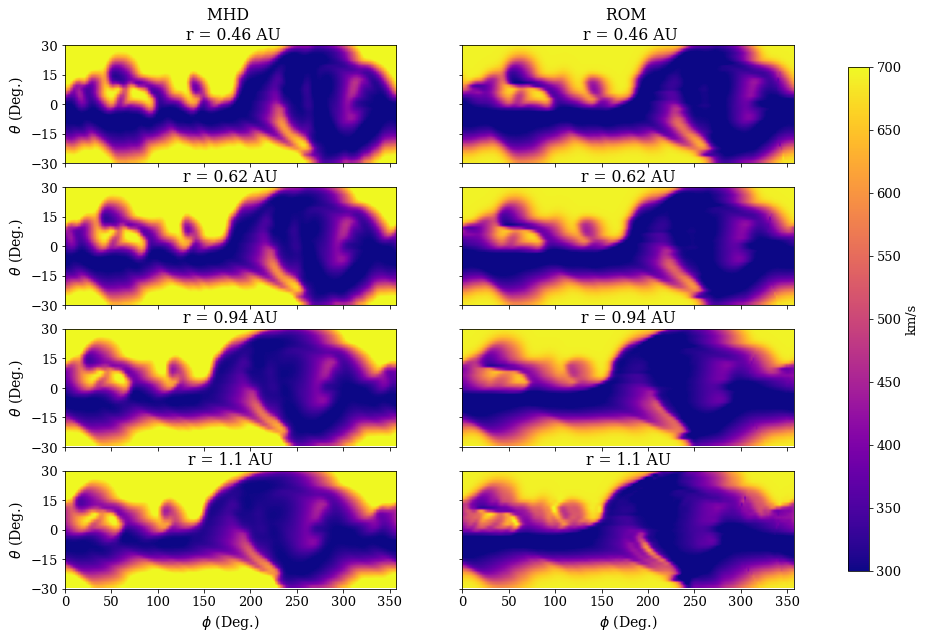

In [27]:
fig, ax = plt.subplots(nrows = 4, ncols=2, figsize=(15, 10), sharex = True, sharey=True)

    
ax[0][0].imshow(f[:, t_min: t_max, len(r)//3].T,
                extent=[p_new[0]*180/np.pi, p_new[-1]*180/np.pi, t[t_min]*180/np.pi, t[t_max]*180/np.pi],   
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")
ax[0][0].set_title("MHD \n r = " + str(round(r[len(r)//3].to(u.AU).value, 2)) + " AU")

ax[1][0].imshow(f[:, t_min: t_max, len(r)//2].T,
                extent=[p_new[0]*180/np.pi, p_new[-1]*180/np.pi, t[t_min]*180/np.pi, t[t_max]*180/np.pi],
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")
ax[1][0].set_title("r = " + str(round(r[len(r)//2].to(u.AU).value, 2)) + " AU")


ax[2][0].imshow(f[:, t_min: t_max, 116].T,
                extent=[p_new[0]*180/np.pi, p_new[-1]*180/np.pi, t[t_min]*180/np.pi, t[t_max]*180/np.pi],
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")
ax[2][0].set_title("r = " + str(round(r[116].to(u.AU).value, 2)) + " AU")



ax[3][0].imshow(f[:, t_min: t_max, -1].T,
                extent=[p_new[0]*180/np.pi, p_new[-1]*180/np.pi, t[t_min]*180/np.pi, t[t_max]*180/np.pi],
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")
ax[3][0].set_title("r = " + str(round(r[-1].to(u.AU).value, 2)) + " AU")


# predicted
ax[0][1].imshow(V_profile[:, len(r_new)//3, :].T, 
                extent=[p_new[0]*180/np.pi, p_new[-1]*180/np.pi, t[t_min]*180/np.pi, t[t_max]*180/np.pi],
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")
ax[0][1].set_title("ROM \n r = " + str(round(r_new[len(r_new)//3].to(u.AU).value, 3)) + " AU")

ax[1][1].imshow(V_profile[:, len(r_new)//2, :].T, 
                extent=[p_new[0]*180/np.pi, p_new[-1]*180/np.pi, t[t_min]*180/np.pi, t[t_max]*180/np.pi],
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")
ax[1][1].set_title("r = " + str(round(r_new[len(r_new)//2].to(u.AU).value, 2)) + " AU")


ax[2][1].imshow(V_profile[:, -100, :].T, 
                     extent=[p_new[0]*180/np.pi, p_new[-1]*180/np.pi, t[t_min]*180/np.pi, t[t_max]*180/np.pi],
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")
ax[2][1].set_title("r = " + str(round(r_new[-100].to(u.AU).value, 2)) + " AU")

im = ax[3][1].imshow(V_profile[:, -1, :].T, 
                     extent=[p_new[0]*180/np.pi, p_new[-1]*180/np.pi, t[t_min]*180/np.pi, t[t_max]*180/np.pi],
                vmin = 300, vmax = 700, cmap="plasma", aspect="auto")
ax[3][1].set_title("r = " + str(round(r_new[-1].to(u.AU).value, 2)) + " AU")

ax[3][1].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)
ax[3][0].set_xlabel(r"$\phi$ (Deg.)", fontsize=14)

ax[0][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
ax[1][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
ax[2][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)
ax[3][0].set_ylabel(r"$\theta$ (Deg.)", fontsize=14)

ax[3][0].set_yticks([-30, -15, 0, 15, 30])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
_ = cbar_ax.set_ylabel('km/s', rotation=90)

plt.savefig("figs/al_latitude_result_linear.png", pad_inches=1)